# Credit Card Fraud Detection

## Data Engineering

### import Libraries

In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

from geopy.geocoders import Nominatim
import time

### Read Data

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Capstone/train_new.csv')


### Describe Data

In [3]:
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,473809,2020-12-14 01:44:50,377234009633447,"fraud_Bahringer, Schoen and Corkery",shopping_pos,1.78,Theresa,Blackwell,F,43576 Kristina Islands,...,39.3716,-77.8229,1925,Systems developer,1966-02-14,c2bd62a8247ce3064998adb44e3d2083,1386985490,39.123481,-77.518174,0
1,36057,2020-07-03 22:31:00,3540416671210051,"fraud_Schmeler, Bashirian and Price",shopping_net,1115.94,Stephanie,Freeman,F,44613 James Turnpike,...,45.7364,-94.1658,6263,"Engineer, water",1944-05-30,23ac0038963b49b09d06a0169123cef3,1372890660,45.518257,-94.170698,1
2,293728,2020-10-09 23:45:19,2235613922823698,fraud_Reynolds-Schinner,misc_pos,6.39,Melissa,Mcclure,F,2027 Snyder Track,...,42.7300,-104.7024,241,Educational psychologist,1980-12-16,efdda74cefb5c031d47d54c5f8bfa7ab,1381362319,43.270808,-104.401393,0
3,441151,2020-12-06 22:45:44,4292743669224718067,"fraud_Stanton, Jakubowski and Baumbach",shopping_net,812.13,Michael,Williams,M,35822 Clayton Street Apt. 679,...,38.2674,-76.4954,5927,Art therapist,1973-06-09,214637c3924cacdc8f4bab26fecfefcb,1386369944,38.256588,-75.754845,1
4,236107,2020-09-14 14:11:17,38530489946071,fraud_Auer LLC,personal_care,14.63,Laura,Johns,F,95835 Garcia Rue,...,34.9572,-81.9916,530,Animal technologist,1989-05-14,a55f701ad9b73474f1e1e0f7f3945eae,1379167877,35.599428,-81.763510,0


**Dataset Column Descriptions**

- **trans_date_trans_time**: The timestamp indicating when the transaction occurred (date and time).  
- **cc_num**: The credit card number used in the transaction.  
- **merchant**: The name or ID of the merchant where the transaction took place.  
- **category**: The type of business or service (e.g., groceries, electronics, fuel).  
- **amt**: The transaction amount (in currency).  
- **first**: The first name of the cardholder.  
- **last**: The last name of the cardholder.  
- **gender**: The gender of the cardholder (e.g., Male, Female).  
- **street**: The street address of the cardholder.  
- **city**: The city where the cardholder resides.  
- **state**: The state where the cardholder resides.  
- **zip**: The ZIP code of the cardholder’s address.  
- **lat**: The latitude of the cardholder’s residence.  
- **long**: The longitude of the cardholder’s residence.  
- **city_pop**: The population of the city where the cardholder lives.  
- **job**: The cardholder’s job title or occupation.  
- **dob**: The date of birth of the cardholder.  
- **trans_num**: A unique identifier for the transaction.  
- **unix_time**: The transaction time in UNIX timestamp format (seconds since January 1, 1970).  
- **merch_lat**: The latitude of the merchant’s location.  
- **merch_long**: The longitude of the merchant’s location.  
- **is_fraud**: A label indicating whether the transaction is fraudulent (1 = fraud, 0 = not fraud).  


In [4]:
#check data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             3000 non-null   int64  
 1   trans_date_trans_time  3000 non-null   object 
 2   cc_num                 3000 non-null   int64  
 3   merchant               3000 non-null   object 
 4   category               3000 non-null   object 
 5   amt                    3000 non-null   float64
 6   first                  3000 non-null   object 
 7   last                   3000 non-null   object 
 8   gender                 3000 non-null   object 
 9   street                 3000 non-null   object 
 10  city                   3000 non-null   object 
 11  state                  3000 non-null   object 
 12  zip                    3000 non-null   int64  
 13  lat                    3000 non-null   float64
 14  long                   3000 non-null   float64
 15  city

In [5]:
df.shape

(3000, 23)

### Drop Unnecessary columns

🚫 Columns to Drop for Fraud Detection

- **first** and **last**: Cardholder names have no influence on fraud detection.  
- **gender**: Gender has no direct correlation with fraudulent activity.  
- **street**: Street address is unlikely to add value for fraud detection.  
- **zip**: ZIP codes are often redundant with city and state information.  
- **lat** and **long**: Redundant with `city` and `state` data.  
- **city_pop**: Population size doesn’t directly indicate fraud.  
- **job**: Irrelevant for predicting fraud.  
- **dob**: Age may be weakly correlated, but it usually has minimal impact.  
- **trans_num**: Just an identifier, not useful for modeling.  
- **unix_time**: Redundant with `trans_date_trans_time`.  


In [6]:
columns = [
    "trans_date_trans_time",
    "merchant",
    "category",
    "amt",
    "city",
    "state",
    "merch_lat",
    "merch_long",
    "is_fraud"
]

# Filter the relevant columns
df = df[columns]


In [7]:
df.head()

,trans_date_trans_time,merchant,category,amt,city,state,merch_lat,merch_long,is_fraud
0,2020-12-14 01:44:50,"fraud_Bahringer, Schoen and Corkery",shopping_pos,1.78,Shenandoah Junction,WV,39.123481,-77.518174,0
1,2020-07-03 22:31:00,"fraud_Schmeler, Bashirian and Price",shopping_net,1115.94,Rice,MN,45.518257,-94.170698,1
2,2020-10-09 23:45:19,fraud_Reynolds-Schinner,misc_pos,6.39,Manville,WY,43.270808,-104.401393,0
3,2020-12-06 22:45:44,"fraud_Stanton, Jakubowski and Baumbach",shopping_net,812.13,Great Mills,MD,38.256588,-75.754845,1
4,2020-09-14 14:11:17,fraud_Auer LLC,personal_care,14.63,Arcadia,SC,35.599428,-81.763510,0


### Checking null values

In [8]:
df.isnull().sum()

,0
trans_date_trans_time,0
merchant,0
category,0
amt,0
city,0
state,0
merch_lat,0
merch_long,0
is_fraud,0


In [9]:



geolocator = Nominatim(user_agent="fraud_detection")

# Function for reverse geocoding
def reverse_geocode(lat, long):
    try:
        location = geolocator.reverse((lat, long), exactly_one=True, timeout=10)
        if location:
            address = location.raw.get('address', {})

            county = address.get('county', '')
            state = address.get('state', '')
            return county, state
        else:
            return None, None
    except Exception as e:
        print(f"Error: {e}")
        return None, None

# Apply reverse geocoding to create new columns
df[['merch_city', 'merch_state']] = df.apply(
    lambda row: pd.Series(reverse_geocode(row['merch_lat'], row['merch_long'])),
    axis=1
)

# Remove redundant columns
df.drop(['merch_lat', 'merch_long'], axis=1, inplace=True)




In [10]:



df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])

# Extract features from datetime
df['hour'] = df['trans_date_trans_time'].dt.hour
df['day_of_week'] = df['trans_date_trans_time'].dt.dayofweek
df['month'] = df['trans_date_trans_time'].dt.month
df['year'] = df['trans_date_trans_time'].dt.year

# Drop the original datetime column
df = df.drop(columns=['trans_date_trans_time'])


label_encoders = {}
categorical_cols = ['merchant', 'category', 'city', 'state','merch_city','merch_state' ]

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

scaler = StandardScaler()
numerical_cols = ['amt', 'hour', 'day_of_week', 'month', 'year']
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])



In [11]:
df.head()

,merchant,category,amt,city,state,is_fraud,merch_city,merch_state,hour,day_of_week,month,year
0,17,12,-0.799883,568,47,0,573,53,-1.501469,-1.337092,1.419905,0.0
1,526,11,2.183628,521,22,1,915,27,1.006021,0.531877,-1.207603,0.0
2,487,9,-0.787539,375,48,0,677,57,1.125425,0.531877,0.368902,0.0
3,564,11,1.370082,228,19,1,895,24,1.006021,1.466362,1.419905,0.0
4,11,10,-0.765473,20,38,0,823,38,0.050787,-1.337092,-0.156599,0.0


In [12]:
output_filename = "credit_card_fraud_mvp.csv"
df.to_csv(output_filename, index=False)

# Display confirmation message
print(f"DataFrame saved as '{output_filename}'")

DataFrame saved as 'credit_card_fraud_mvp.csv'


In [13]:
df.head()

,merchant,category,amt,city,state,is_fraud,merch_city,merch_state,hour,day_of_week,month,year
0,17,12,-0.799883,568,47,0,573,53,-1.501469,-1.337092,1.419905,0.0
1,526,11,2.183628,521,22,1,915,27,1.006021,0.531877,-1.207603,0.0
2,487,9,-0.787539,375,48,0,677,57,1.125425,0.531877,0.368902,0.0
3,564,11,1.370082,228,19,1,895,24,1.006021,1.466362,1.419905,0.0
4,11,10,-0.765473,20,38,0,823,38,0.050787,-1.337092,-0.156599,0.0


In [14]:
fraud_count = df['is_fraud'].value_counts()

In [15]:

# Separate features and target
X = df.drop('is_fraud', axis=1)
y = df['is_fraud']

# Split into training and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (2400, 11)
Test shape: (600, 11)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:25:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


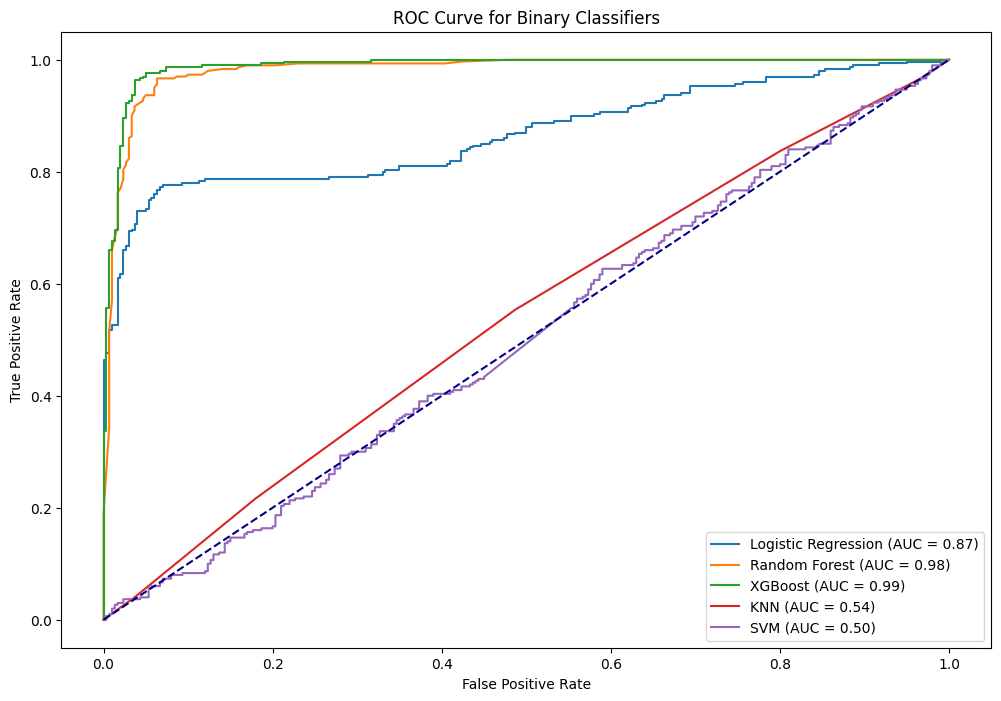


📊 Model Evaluation Results:
                 Model  Accuracy  Precision    Recall  F1 Score   AUC-ROC
0  Logistic Regression  0.848333   0.923077  0.760000  0.833638  0.866933
1        Random Forest  0.938333   0.939799  0.936667  0.938230  0.981717
2              XGBoost  0.960000   0.953947  0.966667  0.960265  0.988100
3                  KNN  0.533333   0.532051  0.553333  0.542484  0.538017
4                  SVM  0.515000   0.512465  0.616667  0.559758  0.501161


In [16]:


models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVM": SVC(probability=True, random_state=42)
}


results = []


plt.figure(figsize=(12, 8))

for name, model in models.items():

    model.fit(X_train, y_train)


    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)


    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_prob)

    # Store results
    results.append({
        "Model": name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "AUC-ROC": auc_score
    })

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.2f})")

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Binary Classifiers")
plt.legend()
plt.show()


results_df = pd.DataFrame(results)
print("\n📊 Model Evaluation Results:")
print(results_df)
